# Quality Control of Whole Genome Sequencing

## Helper function

In [62]:
import os
import json
import pandas as pd
from pandas import json_normalize

# Ignore FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress the UserWarning related to 'palette' and other warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Function to flatten the JSON and keep only leaf nodes
def flatten_json(json_obj, prefix=''):
    flat_data = {}
    for key, value in json_obj.items():
        # Check if value is a dictionary (i.e., nested) or if it's a leaf node
        if isinstance(value, dict):
            flat_data.update(flatten_json(value))  # Recursively flatten nested dictionaries
        else:
            flat_data[key] = value  # Leaf node, add to flat_data
    return flat_data

# Function to load the JSON in a DataFrame
def load_metrics(directory):
    
    # Initialize an empty list to store the parsed JSON data
    data_list = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".metrics.json"):  # Only process .json files
            filepath = os.path.join(directory, filename)
            # Open and load each JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
                # Flatten the JSON and keep only leaf nodes
                flat_data = flatten_json(data)
                # Append to the data list
                data_list.append(flat_data)
    
    # Create a DataFrame from the list of flat data
    df = pd.DataFrame(data_list)
    # Append sample info
    return append_info(df)

## Append sample info
def append_info(df):
    df_info = pd.read_csv('../n.100-1kg-samples_info_igsr.csv')
    df_merged = df.merge(df_info, left_on='id', right_on='Sample_name')
    return df_merged

# Function that plot the distribution of each metric in metrics.json file
def distribution(df, hue=None, palette='Set2'):
    # For each metric
    for col in df.columns[1:17]:
        # Create a scatter plot
        plt.figure(figsize=(10, 4))
        sns.scatterplot(data=df, x=df.index, y=col, hue=hue, palette=palette)
    
        # Calculate median and MAD
        median = df[col].median()
        # mad = np.mean(np.abs(dft[col] - median))
        
        # Add median and +/-3MAD lines
        plt.axhline(y=median, linestyle='--', color='red', label='Median')
        # plt.axhline(y=median + 3 * mad, linestyle='--', color='orange', label='+3xMAD')
        # plt.axhline(y=median - 3 * mad, linestyle='--', color='orange', label='-3xMAD')
        
        # Set plot title and labels
        plt.title(f"Scatter Plot for {col}")
        plt.xlabel("sample")
        plt.ylabel(col)
        plt.xticks([]) # Hide x-axis labels

        # if col in ylims:
        #     plt.ylim(ylims[col][0], ylims[col][1])
    
        # Show legend
        plt.legend()
    
        # Show the plot
        plt.show()

## Load metrics.json

In [63]:
dir = '../results-npm-sample-qc-v0.13.0'
df = load_metrics(dir)
df

,id,cross_contamination_rate,insert_size_std_deviation,mad_autosome_coverage,mean_autosome_coverage,mean_insert_size,pct_autosomes_15x,pct_reads_mapped,pct_reads_properly_paired,yield_bp_q30,...,ratio_transitions_transversions_snv,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,NA20298,1.879880e-06,100.7,5,32.30,445.6,95.91,99.71,97.9,109403663177,...,1.97,NA20298,male,SAME124382,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,NA20317,6.123190e-09,101.0,4,30.72,443.5,95.89,99.72,97.8,105461703830,...,1.97,NA20317,female,SAME123943,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA20342,2.665030e-09,99.9,5,31.31,439.7,95.96,99.75,97.8,109449901862,...,1.97,NA20342,male,SAME124398,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,NA21133,3.397340e-09,104.0,5,41.01,451.8,96.36,99.71,98.1,138827812751,...,1.95,NA21133,male,SAME123831,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,NA21126,8.025660e-10,95.0,4,29.75,418.2,95.81,99.53,97.6,102865521454,...,1.96,NA21126,male,SAME124026,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NA21112,1.952810e-06,100.9,5,32.38,437.2,96.03,99.72,97.8,109002390109,...,1.96,NA21112,male,SAME124182,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,NA21115,1.562780e-06,101.0,5,37.29,440.2,96.23,99.75,98.1,125097444900,...,1.96,NA21115,male,SAME124183,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,NA21100,1.254850e-09,98.0,4,29.22,422.8,95.67,99.52,97.6,96776159556,...,1.96,NA21100,male,SAME124440,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,NA21088,5.514270e-06,99.7,5,33.25,434.0,96.03,99.73,98.2,110451940888,...,1.96,NA21088,female,SAME123143,GIH,Gujarati,SAS,South Asian Ancestry,GIH,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


## Display metrics distribution

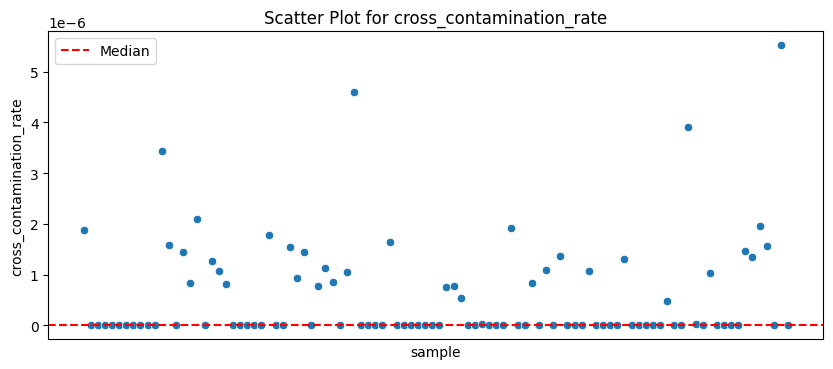

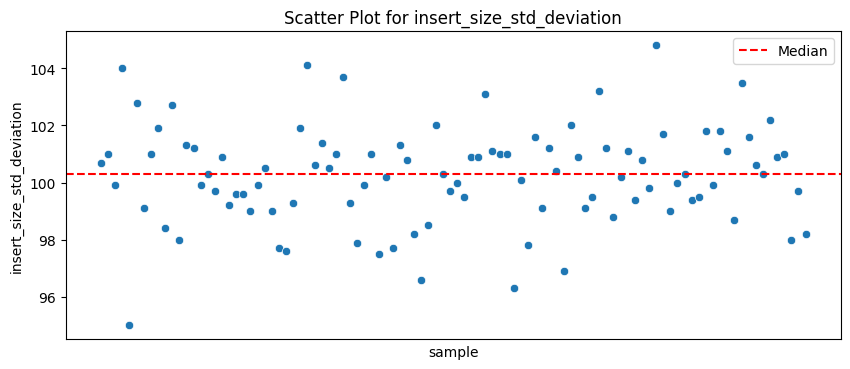

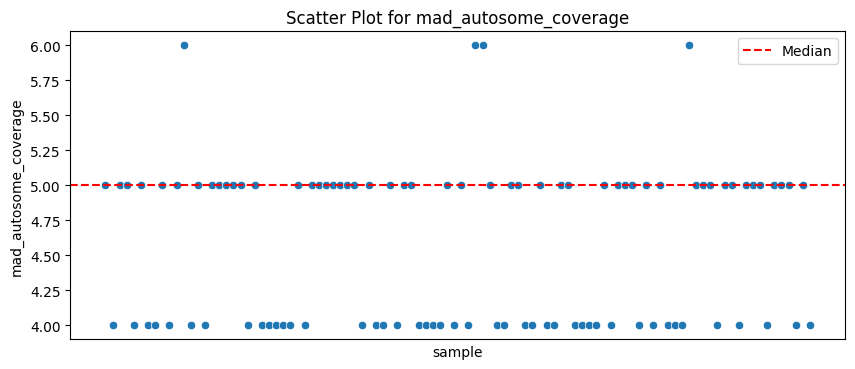

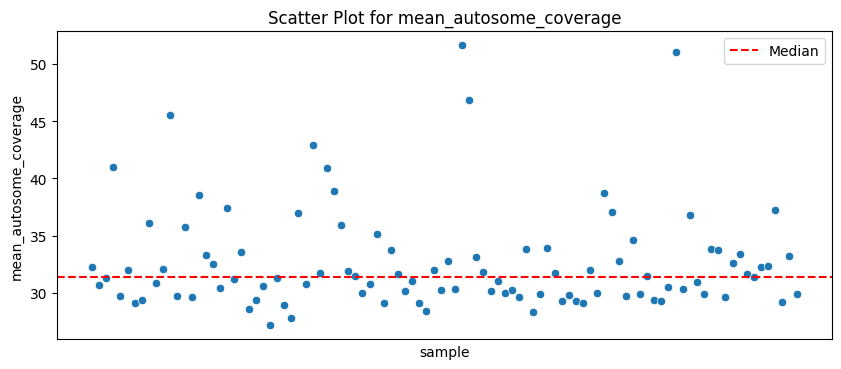

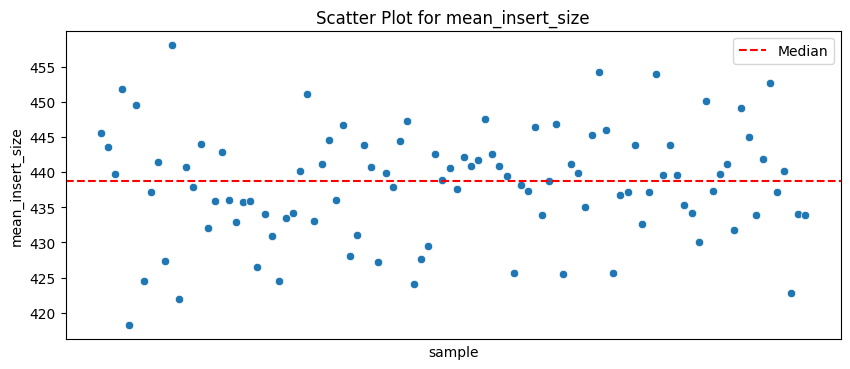

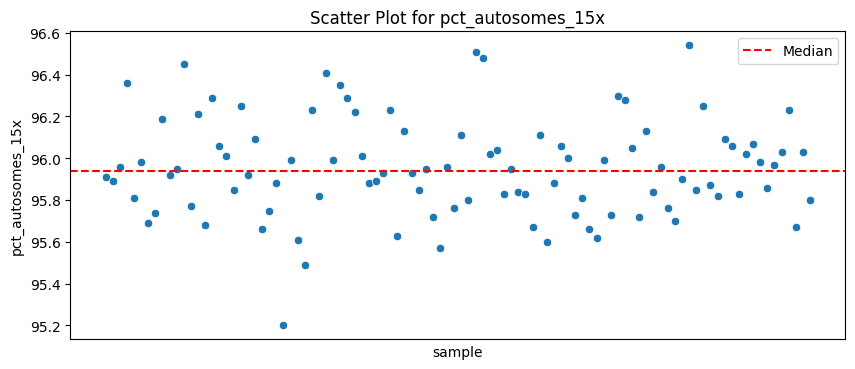

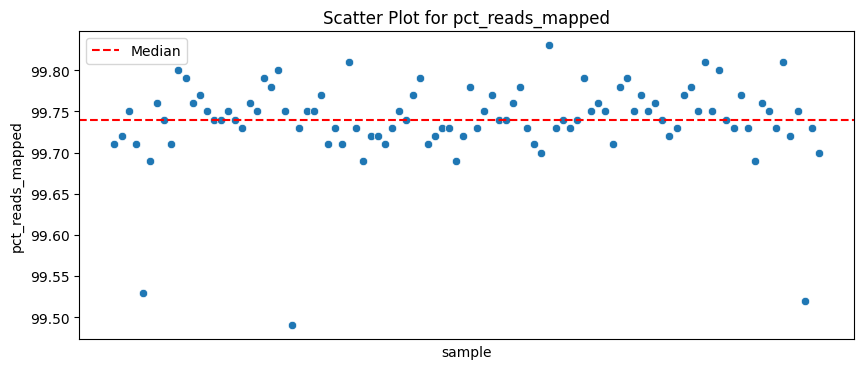

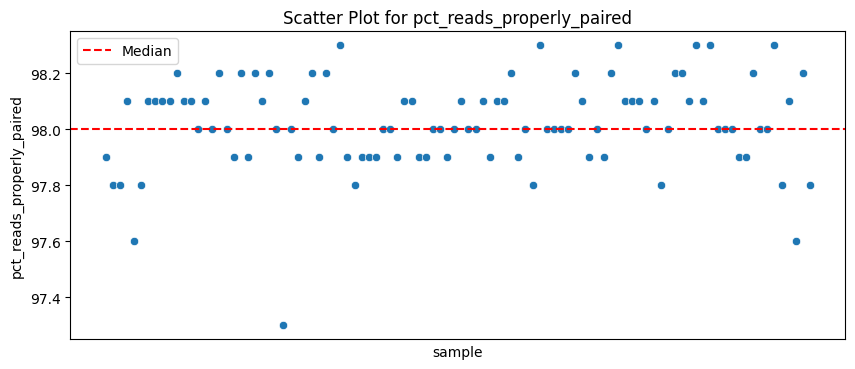

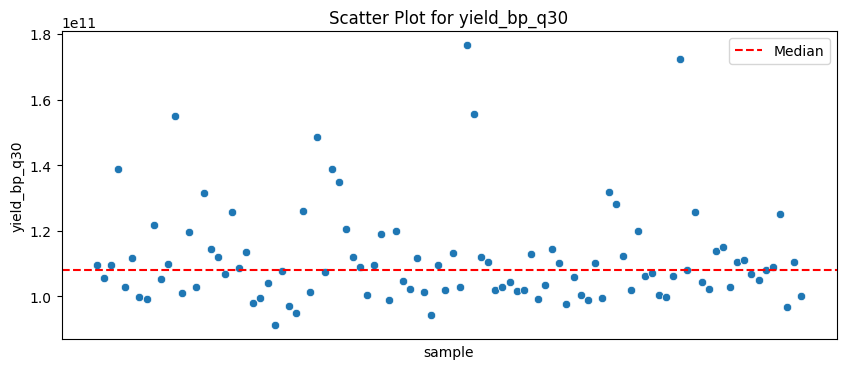

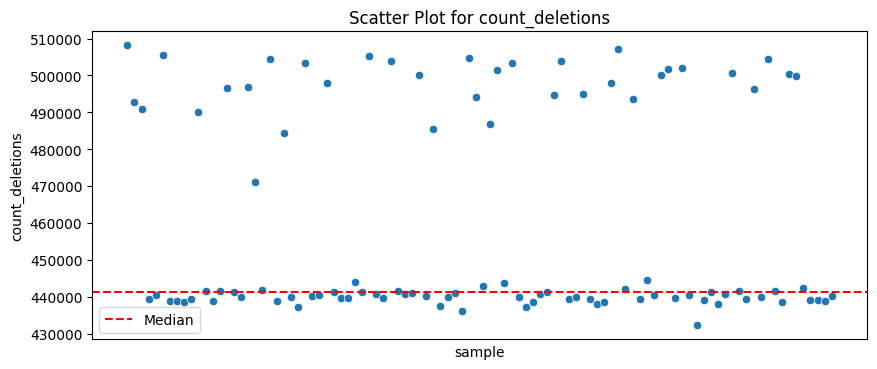

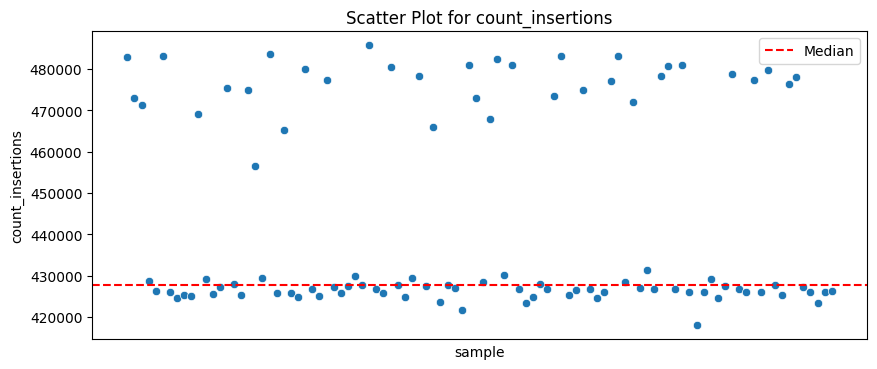

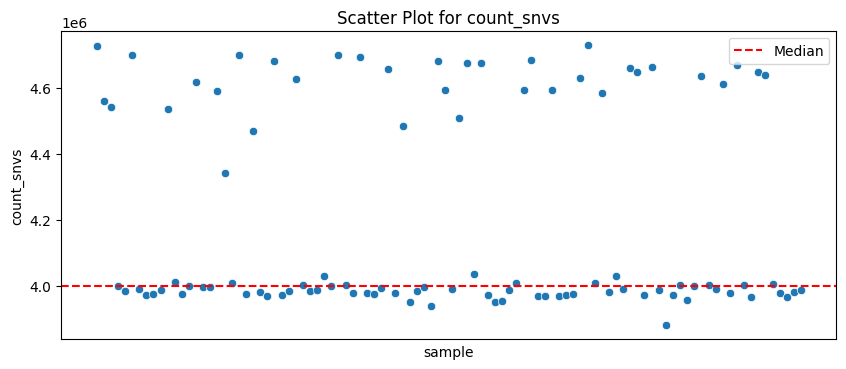

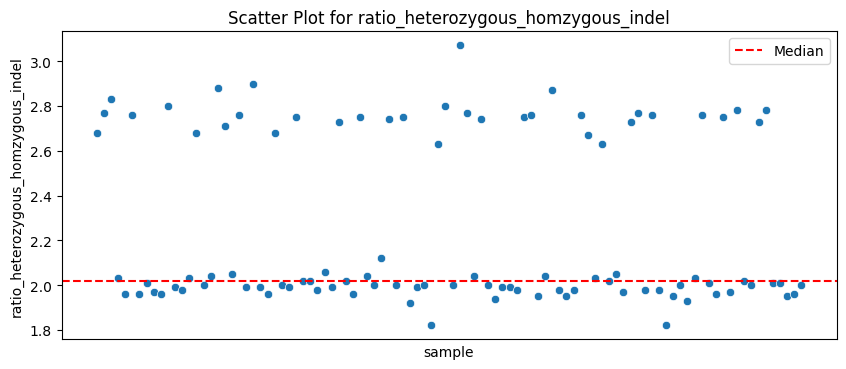

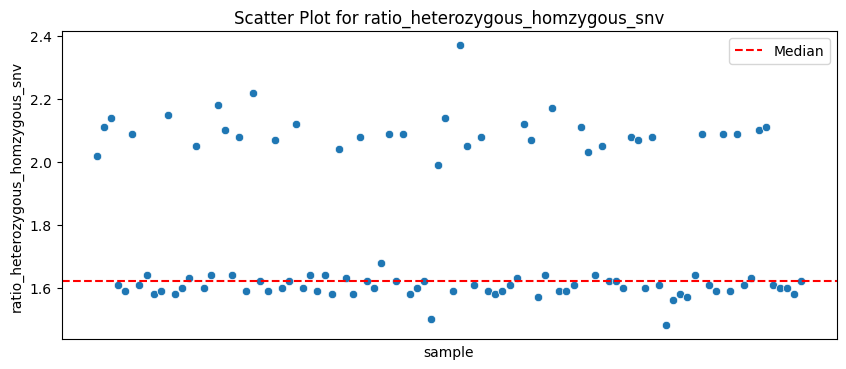

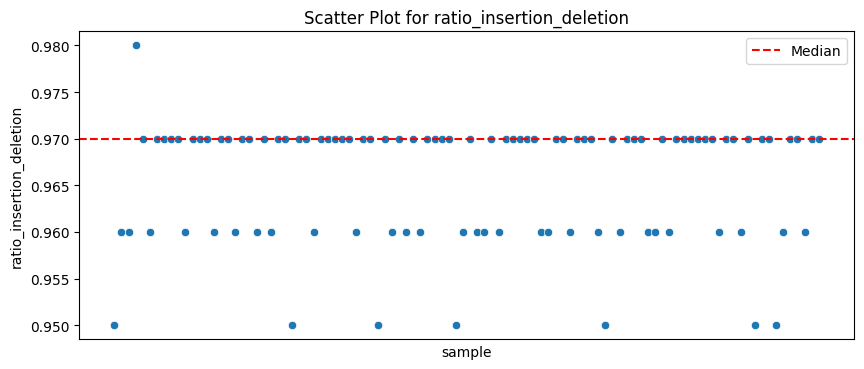

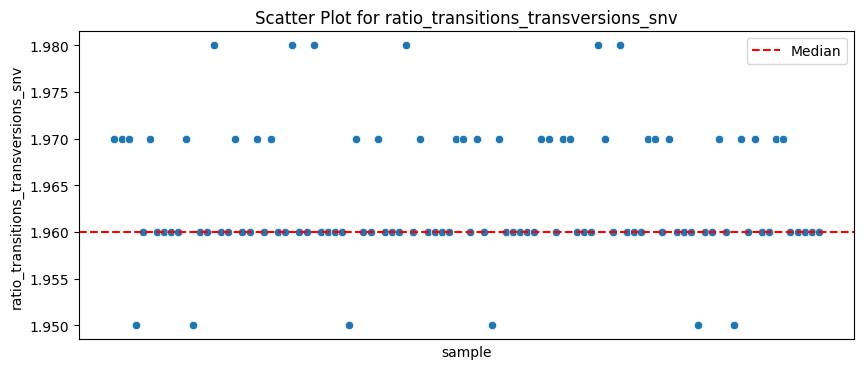

In [64]:
# Plot distribution for each metric
distribution(df)

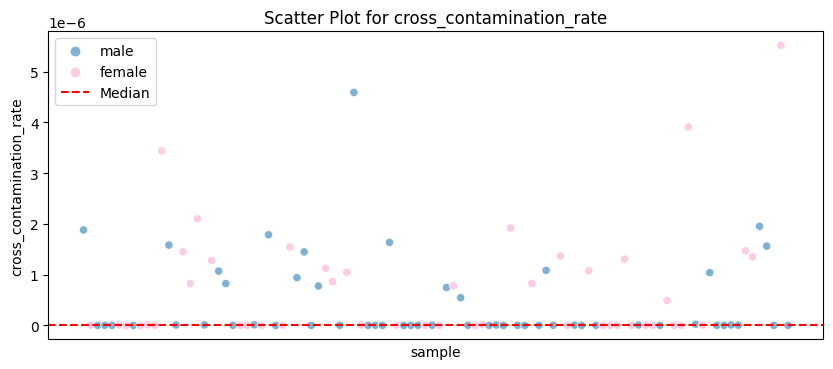

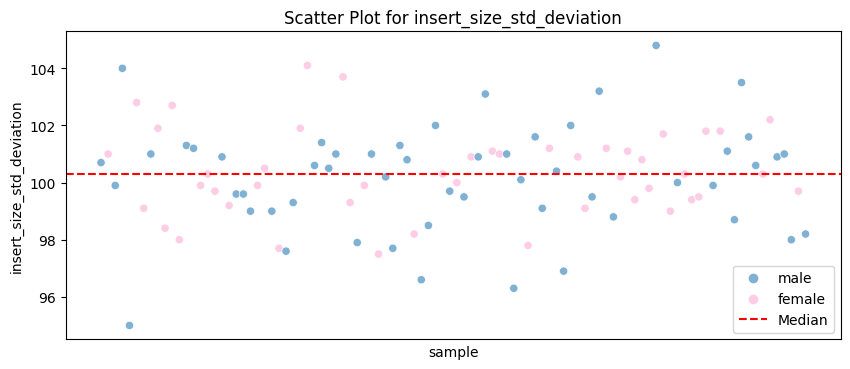

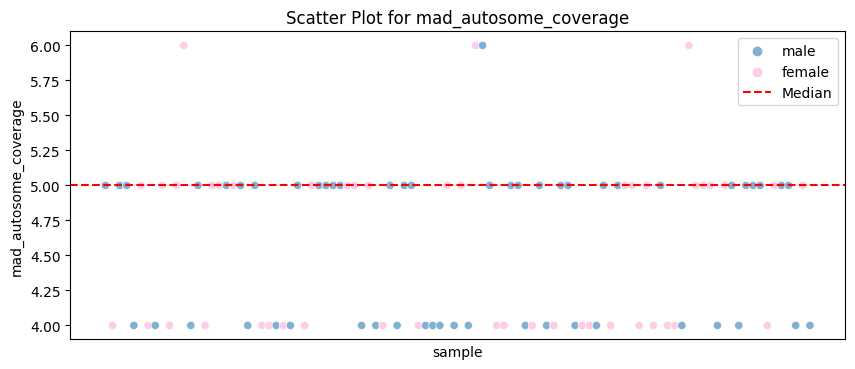

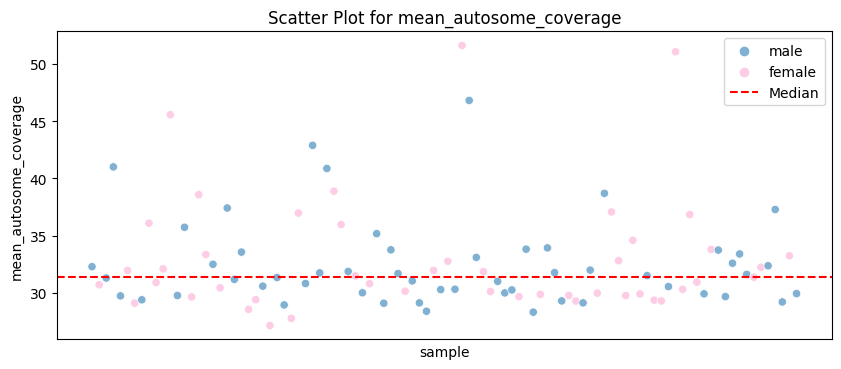

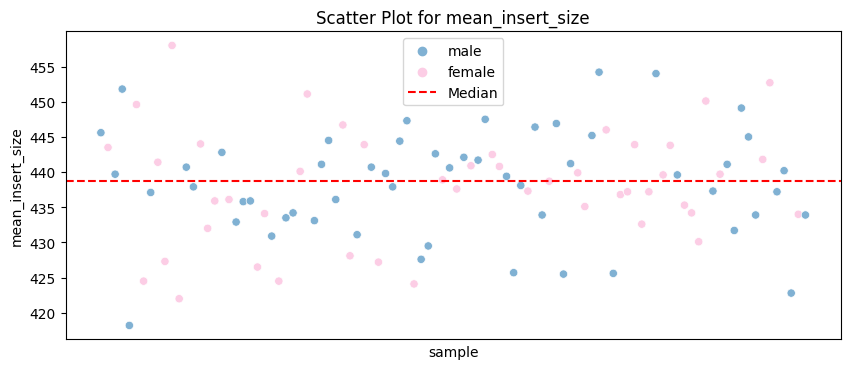

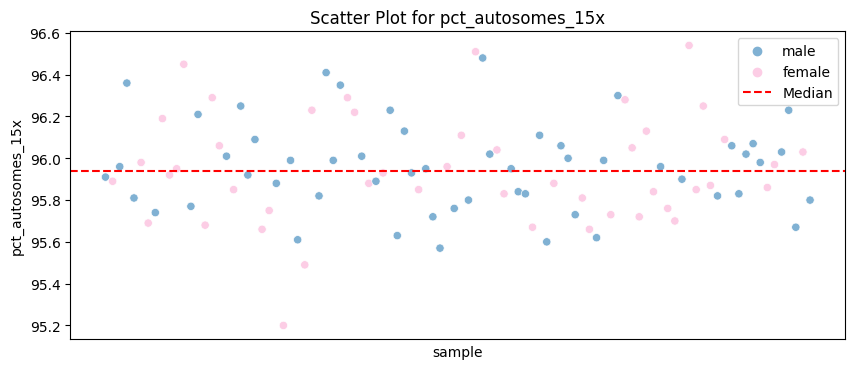

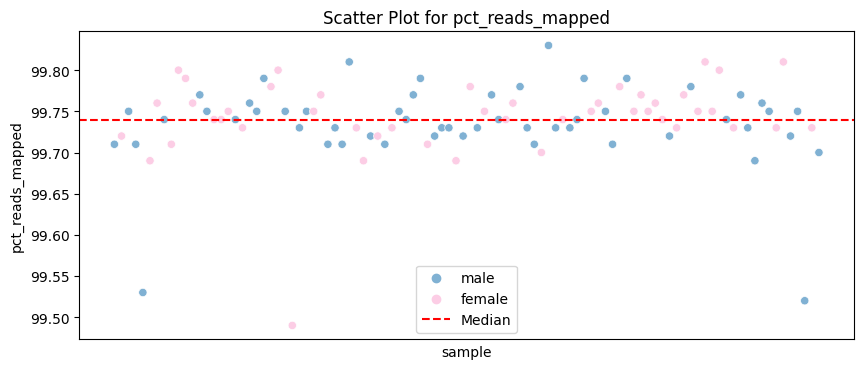

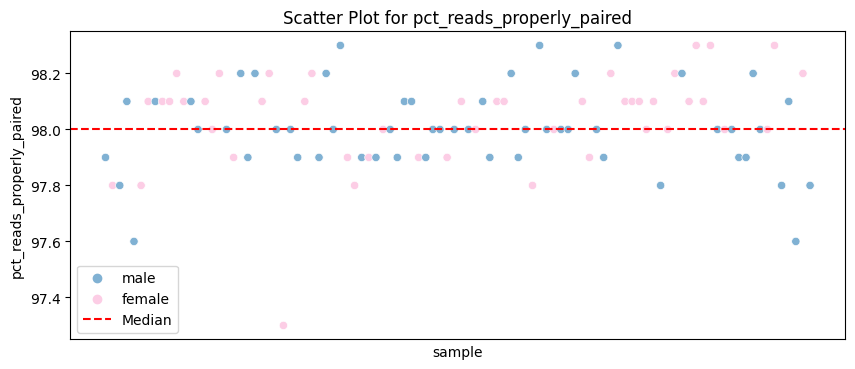

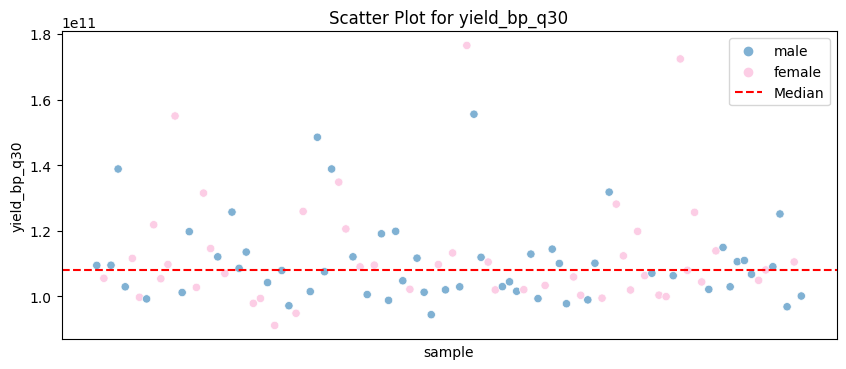

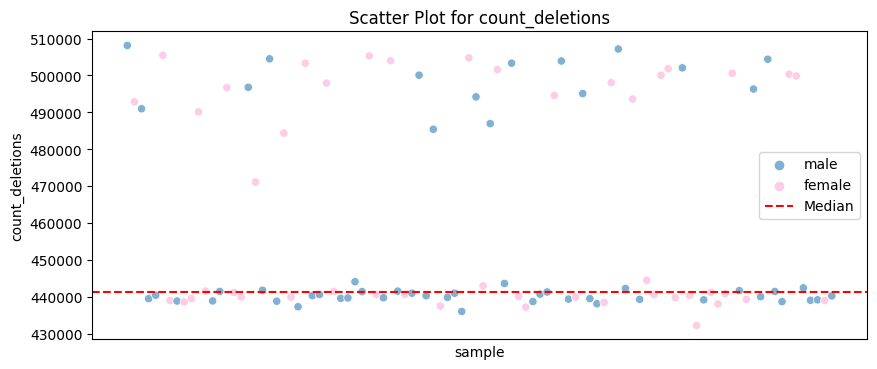

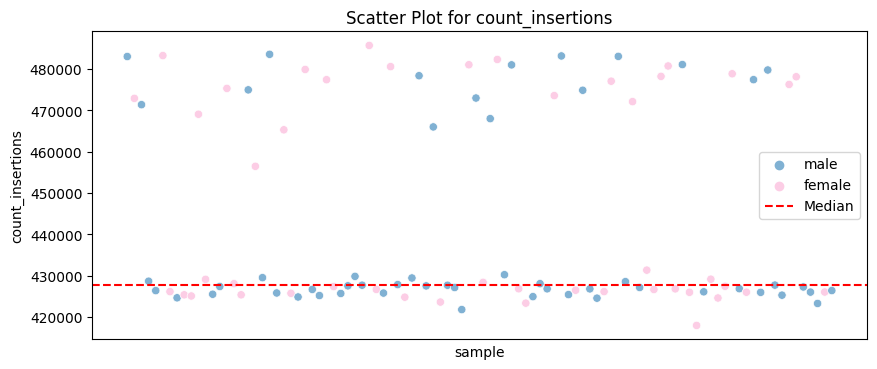

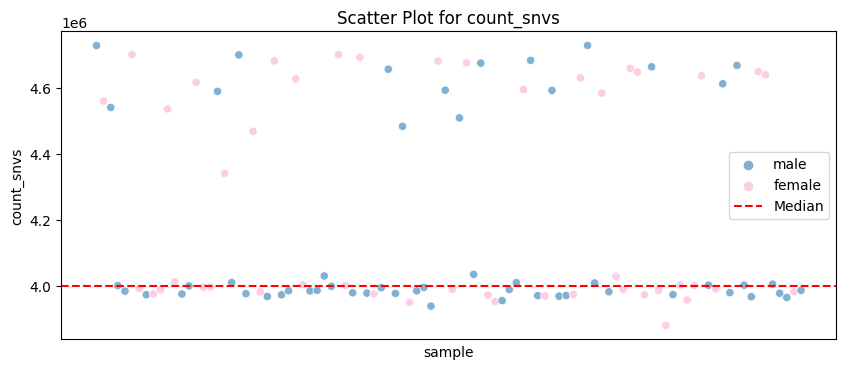

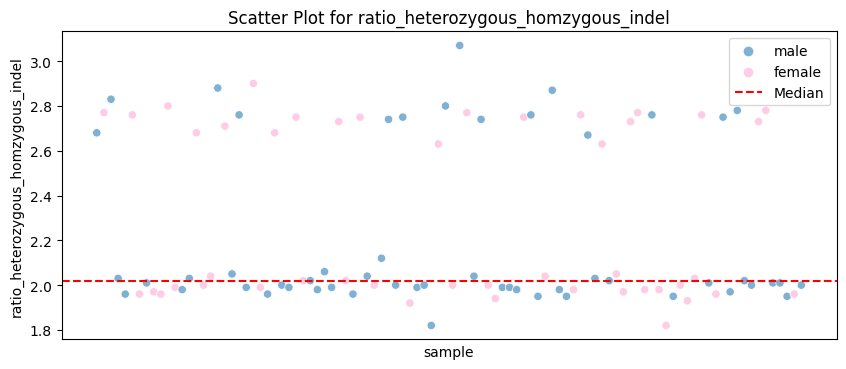

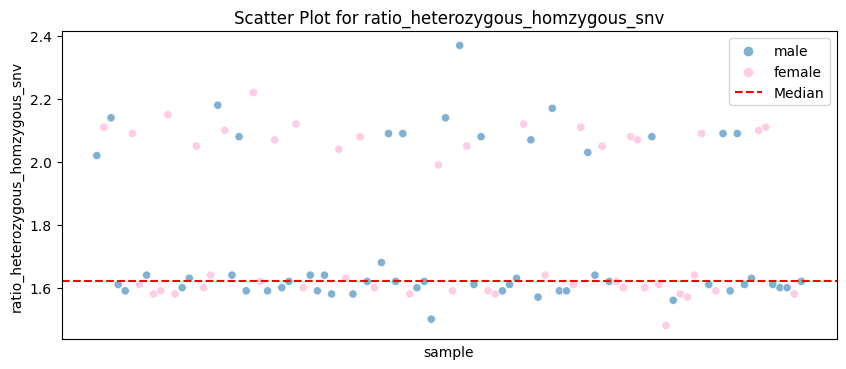

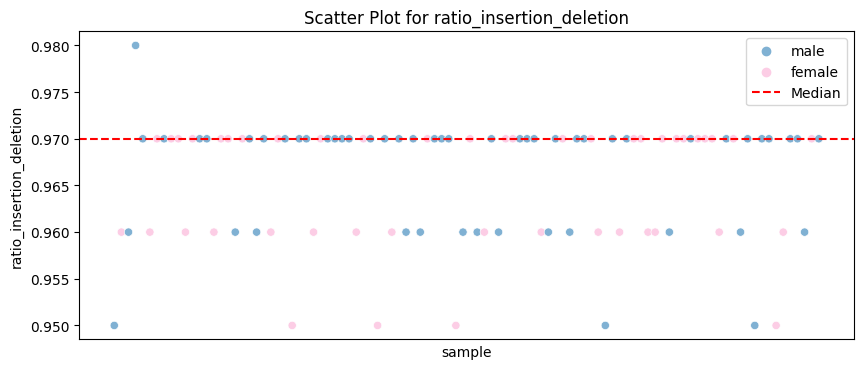

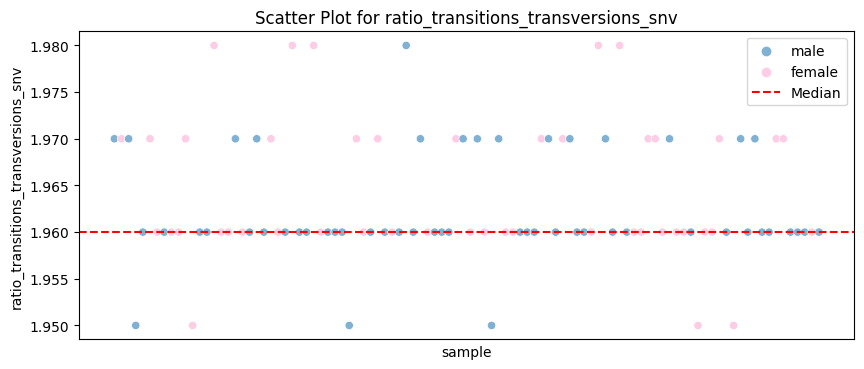

In [65]:
distribution(df, 'Sex', {'male':'#80b1d3', 'female': '#fccde5'})

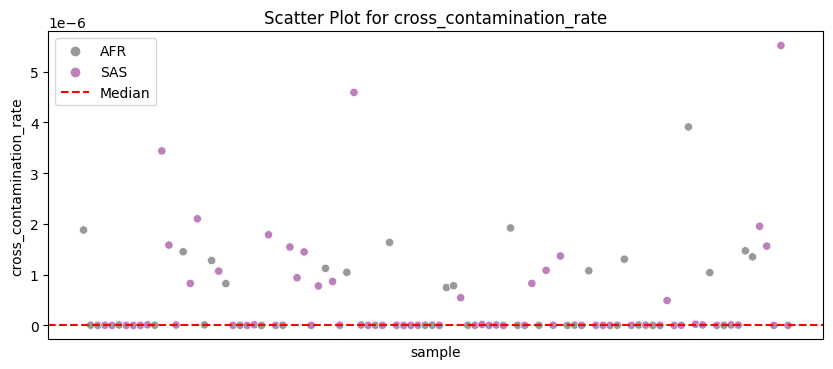

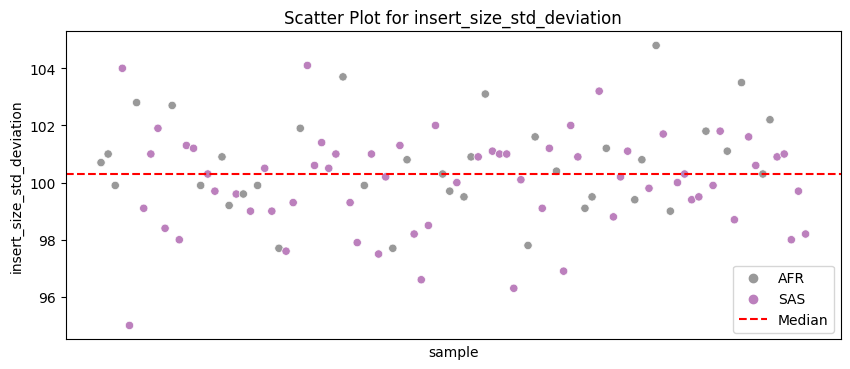

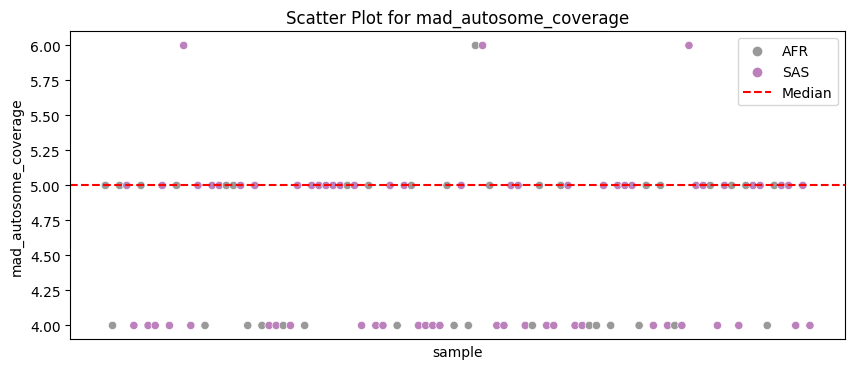

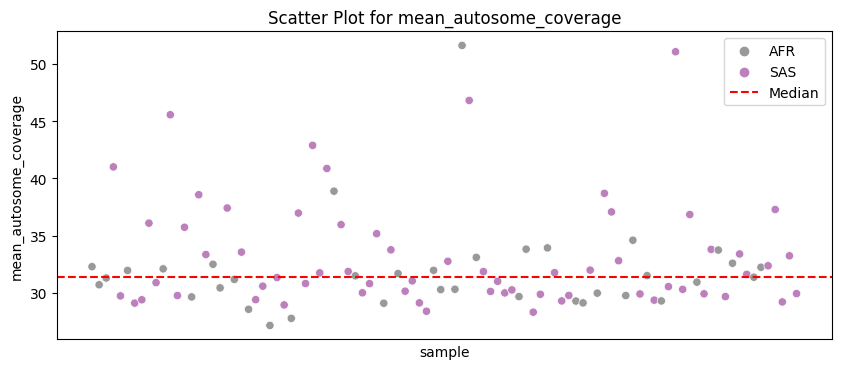

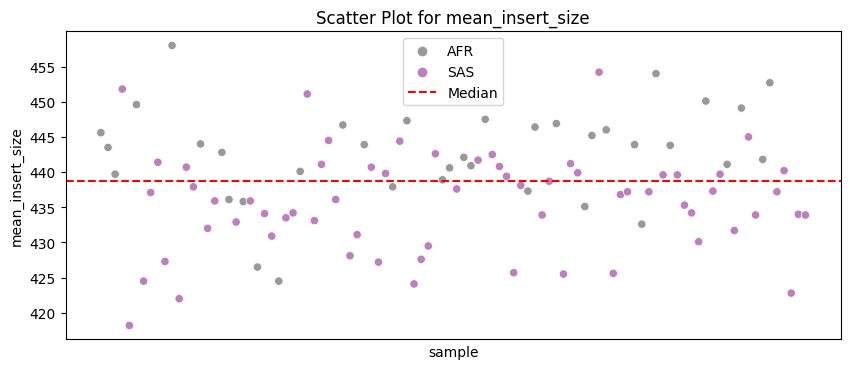

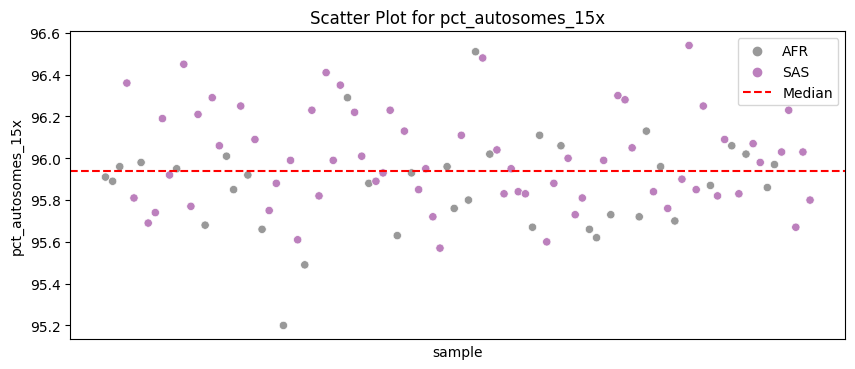

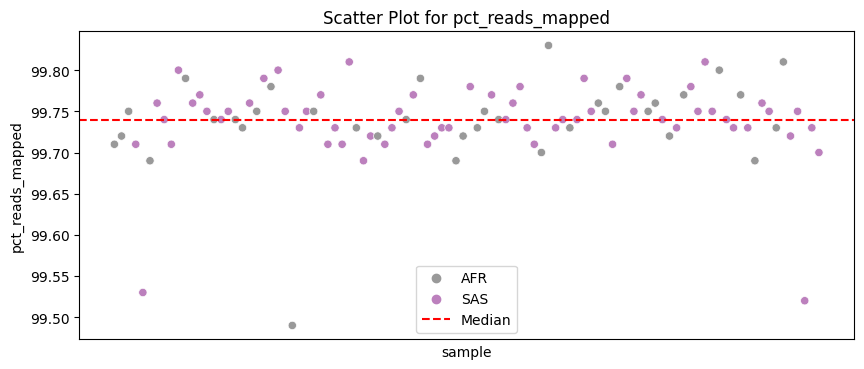

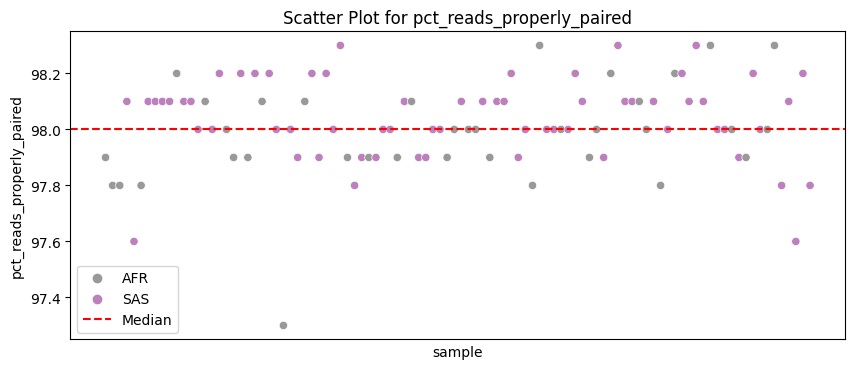

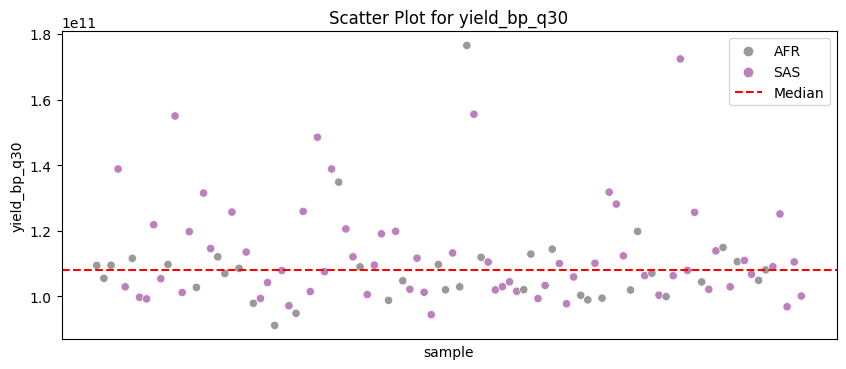

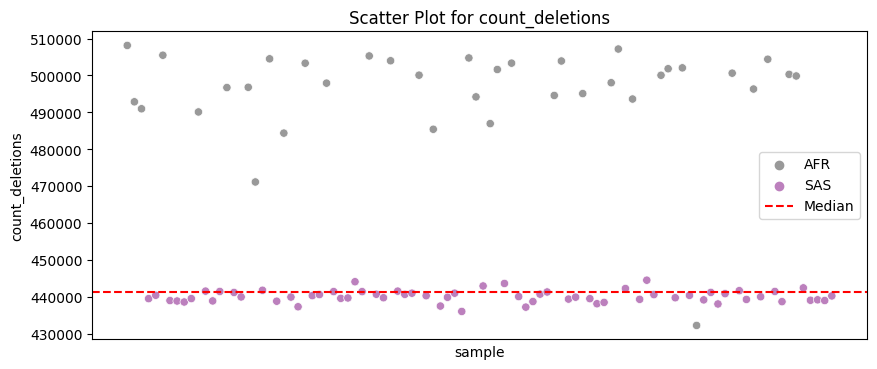

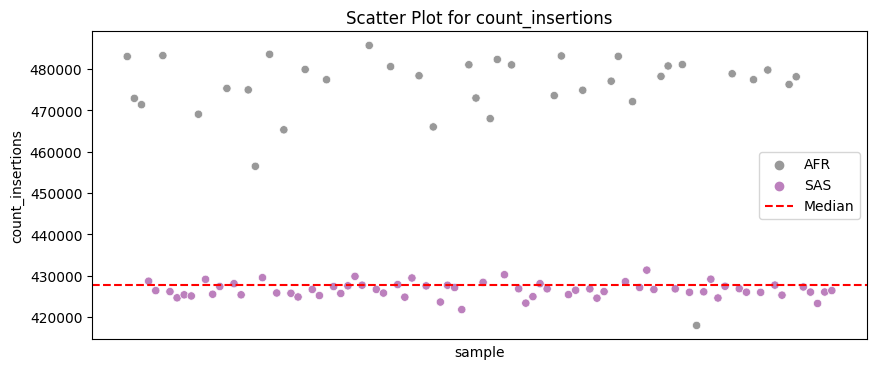

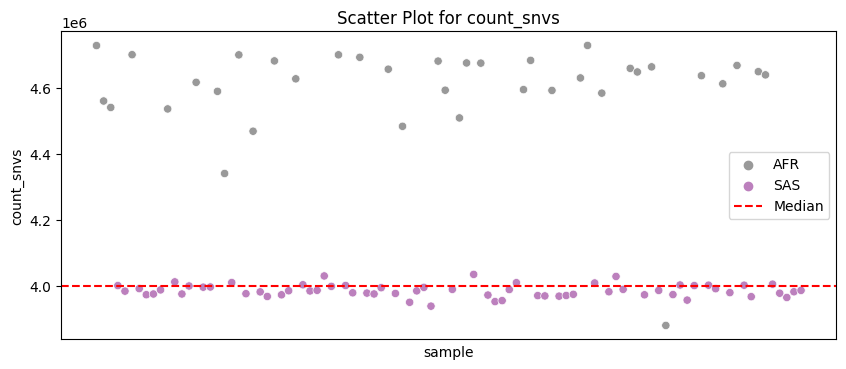

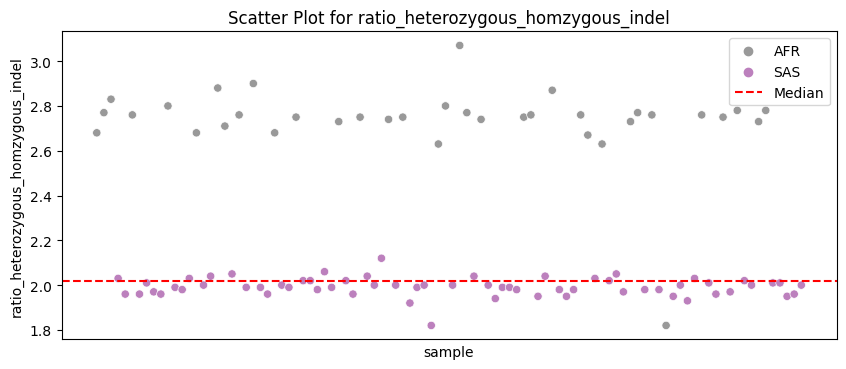

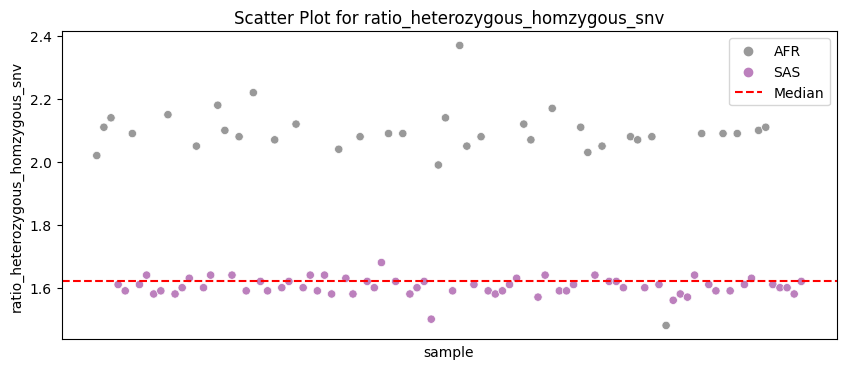

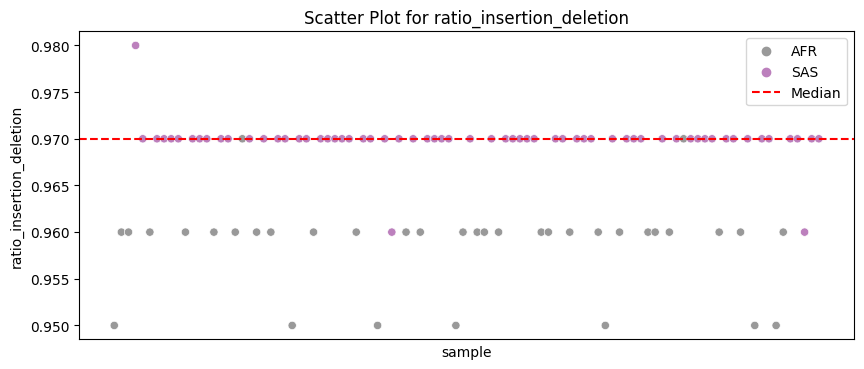

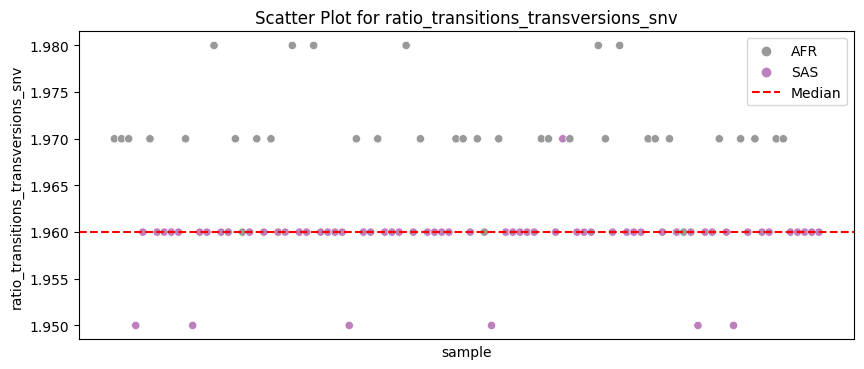

In [66]:
distribution(df, 'Superpopulation_code', {'AFR': '#999999', 'SAS': '#bc80bd'})